In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [2]:
dataDirectory = ''
workingDirectory = '/home/h1bennet/strains/results/01_Strains_AMLNtoControl_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

### Read in raw gene expression files

write raw peak files for each strain

In [3]:
best_reps = [
    '00_C57_Kupffer_H3K27Ac_control_young_C571A_170915',
    '00_C57_Kupffer_H3K27Ac_control_young_C572A_180423',
    '01_balbc_Kupffer_H3K27Ac_control_young_Balb10ABC_170915',
    '01_balbc_Kupffer_H3K27Ac_control_young_Balb11AB_170915',
    '02_aj_Kupffer_H3K27Ac_control_young_AJ10ABC_161208',
    '02_aj_Kupffer_H3K27Ac_control_young_AJ11AB_161208',
    '00_C57_Kupffer_H3K27Ac_AMLNDiet_20weeks_C579A_180423',
    '00_C57_Kupffer_H3K27Ac_AMLNDiet_20weeks_C579C_180423',
    '01_balbc_Kupffer_H3K27Ac_AMLNDiet_30weeks_Balb14D_180423',
    '01_balbc_Kupffer_H3K27Ac_AMLNDiet_30weeks_Balb6AB_180423',
    '02_aj_Kupffer_H3K27Ac_AMLNDiet_30weeks_AJ15B_180423',
    '02_aj_Kupffer_H3K27Ac_AMLNDiet_30weeks_AJ6A_180423']

In [4]:
df, mat = read_annotated_peaks('./ann_raw_kc_amln_atac_peaks_all.txt')

Check that we are selecting the proper samples and the column order since we need this info for running get diff expressssion.

In [5]:
strains = ['C57', 'balbc', 'aj']
df, mat = read_annotated_peaks('./ann_raw_kc_amln_atac_peaks_all.txt')
df.index.rename('PeakID')
# drop bad qc samples
tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains('|'.join(best_reps)))
df = df.loc[:, tst]
mat = mat.loc[:, mat.columns.str.contains('|'.join(best_reps))]

for strain in strains:
    print(strain)
    # pull out selected strain
    tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains(strain))
    # print(tst)
    tmp = df.loc[:, tst]
    print(tmp.columns)
    tmp.to_csv('./'+strain+'_ann_raw_kc_amln_atac_peaks_all.txt', sep='\t')

C57
Index(['Chr', 'Start', 'End', 'Strand', 'Peak Score',
       'Focus Ratio/Region Size', 'Annotation', 'Detailed Annotation',
       'Distance to TSS', 'Nearest PromoterID', 'Entrez ID', 'Nearest Unigene',
       'Nearest Refseq', 'Nearest Ensembl', 'Gene Name', 'Gene Alias',
       'Gene Description', 'Gene Type',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/00_C57_Kupffer_H3K27Ac_control_young_C571A_170915',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/control/00_C57_Kupffer_H3K27Ac_control_young_C572A_180423',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/AMLN_30week/00_C57_Kupffer_H3K27Ac_AMLNDiet_20weeks_C579A_180423',
       '/gpfs/data01/glasslab/home/h1bennet/strains/data/H3K27Ac/AMLN_30week/00_C57_Kupffer_H3K27Ac_AMLNDiet_20weeks_C579C_180423'],
      dtype='object')
balbc
Index(['Chr', 'Start', 'End', 'Strand', 'Peak Score',
       'Focus Ratio/Region Size', 'Annotation', 'Detailed Annotation',
       'Dist

#### Run getDifferentialExpression for all samples

In [6]:
# %%bash
# source activate deseq_36
# getDiffExpression.pl ./C57_ann_raw_kc_amln_atac_peaks_all.txt \
# 00_c57_control 00_c57_control \
# 01_c57_amln 01_c57_amln \
# -peaks > ./C57_diff_output.txt


In [7]:
# %%bash
# source activate deseq_36
# getDiffExpression.pl ./balbc_ann_raw_kc_amln_atac_peaks_all.txt \
# 00_balbc_control 00_balbc_control \
# 01_balbc_amln 01_balbc_amln \
# -peaks > ./balbc_diff_output.txt

In [8]:
# %%bash
# source activate deseq_36
# getDiffExpression.pl ./aj_ann_raw_kc_amln_atac_peaks_all.txt \
# 00_aj_control 00_aj_control \
# 00_aj_amln 00_aj_amln \
# -peaks > ./aj_diff_output.txt

# Scatter plot of differentially acetylated enhancers

## C57

In [9]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './C57_diff_output.txt',
    './ann_norm_kc_amln_atac_peaks_all.txt')

annotatePeaks all peaks (49106, 31)
getDiffExpression selected transcripts (48031, 25)
annotatePeaks selected peaks (48031, 31)


In [10]:
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')
comp_dict.keys()

dict_keys(['00_c57_control vs. 01_c57_amln'])

In [11]:
comps = ['00_c57_control vs. 01_c57_amln']

cols = [[0,1,6,7]]

groups = [[[0,1],[6,7]]]

colors = [['#74c476', '#006d2c']]

00_c57_control vs. 01_c57_amln
N genes downregulated 2489
N genes upregulated 3119



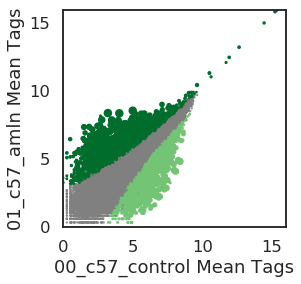

In [12]:
for key, col, group, color in zip(comps, cols, groups, colors):
#     print(key)
#     print('mean calculated using tag dirs:')
#     for colid in peak_mat.iloc[:, col].columns.tolist():
#         print(colid)
#     print('')
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    for index, row in de.iterrows():
        if (row.adj_pval <= 0.05) & (-row.log2fc < 0):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= 0.05) & (-row.log2fc > 0):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    print(key)
    print('N genes downregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)))
    print('N genes upregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)))
    print('')
    fig, axs = plt.subplots(1, 2, figsize=(10,6))
    plt.subplots_adjust(wspace=0.5)

    axs[0].set_xlim(left=-np.ceil(np.max(np.abs(de.log2fc))),
                right=np.ceil(np.max(np.abs(de.log2fc))))
    axs[0].scatter(
        x=de.log2fc,
        y=de.logtpm,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)

    axs[0].set_ylabel('Mean Log2(TPM)')
    axs[0].set_xlabel('Log2FC')

    # plot group by group scatter:
    axs[1].scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    axs[1].set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    axs[1].set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    axs[1].set_xlim([0,np.ceil(countmax)])
    axs[1].set_ylim([0,np.ceil(countmax)])
                      
    plt.savefig('./figures/'+key+'_MAPlot_scatter.png', bbox_inches='tight')
    plt.close()
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
#     ax.text(0.5,15,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
#         fontsize=12,
#         c=color[1])
#     ax.text(15,0.5,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
#         fontsize=12,
#         c=color[0],
#         rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter_notext.png', bbox_inches='tight')
    # plt.close()

## AJ

In [13]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './aj_diff_output.txt',
    './ann_norm_kc_amln_atac_peaks_all.txt')
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')
comp_dict.keys()

annotatePeaks all peaks (49106, 31)
getDiffExpression selected transcripts (48031, 25)
annotatePeaks selected peaks (48031, 31)


dict_keys(['00_aj_control vs. 00_aj_amln'])

In [14]:
comps = ['00_aj_control vs. 00_aj_amln']

cols = [[4,5,10,11]]

groups = [[[4,5],[10,11]]]

colors = [['#fb6a4a', '#a50f15']]

00_aj_control vs. 00_aj_amln
N genes downregulated 1038
N genes upregulated 1608



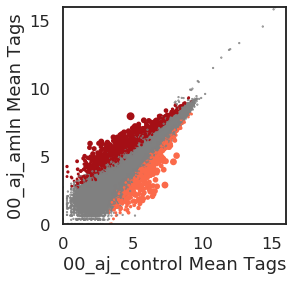

In [15]:
for key, col, group, color in zip(comps, cols, groups, colors):
#     print(key)
#     print('mean calculated using tag dirs:')
#     for colid in peak_mat.iloc[:, col].columns.tolist():
#         print(colid)
#     print('')
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    for index, row in de.iterrows():
        if (row.adj_pval <= 0.05) & (-row.log2fc < 0):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= 0.05) & (-row.log2fc > 0):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    print(key)
    print('N genes downregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)))
    print('N genes upregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)))
    print('')
    fig, axs = plt.subplots(1, 2, figsize=(10,6))
    plt.subplots_adjust(wspace=0.5)

    axs[0].set_xlim(left=-np.ceil(np.max(np.abs(de.log2fc))),
                right=np.ceil(np.max(np.abs(de.log2fc))))
    axs[0].scatter(
        x=de.log2fc,
        y=de.logtpm,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)

    axs[0].set_ylabel('Mean Log2(TPM)')
    axs[0].set_xlabel('Log2FC')

    # plot group by group scatter:
    axs[1].scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    axs[1].set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    axs[1].set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    axs[1].set_xlim([0,np.ceil(countmax)])
    axs[1].set_ylim([0,np.ceil(countmax)])
                      
    plt.savefig('./figures/'+key+'_MAPlot_scatter.png', bbox_inches='tight')
    plt.close()
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
#     ax.text(0.5,15,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
#         fontsize=12,
#         c=color[1])
#     ax.text(15,0.5,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
#         fontsize=12,
#         c=color[0],
#         rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter_notext.png', bbox_inches='tight')
    # plt.close()

## BALBc

In [16]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './balbc_diff_output.txt',
    './ann_norm_kc_amln_atac_peaks_all.txt')
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')
comp_dict.keys()

annotatePeaks all peaks (49106, 31)
getDiffExpression selected transcripts (48031, 25)
annotatePeaks selected peaks (48031, 31)


dict_keys(['00_balbc_control vs. 01_balbc_amln'])

In [17]:
comps = ['00_balbc_control vs. 01_balbc_amln']

cols = [[2,3,8,9]]

groups = [[[2,3],[8,9]]]

colors = [['#6baed6', '#08519c']]

00_balbc_control vs. 01_balbc_amln
N genes downregulated 90
N genes upregulated 107



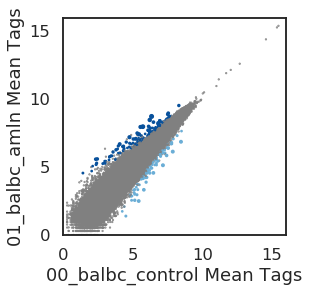

In [18]:
for key, col, group, color in zip(comps, cols, groups, colors):
#     print(key)
#     print('mean calculated using tag dirs:')
#     for colid in peak_mat.iloc[:, col].columns.tolist():
#         print(colid)
#     print('')
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    for index, row in de.iterrows():
        if (row.adj_pval <= 0.05) & (-row.log2fc < 0):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= 0.05) & (-row.log2fc > 0):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('grey')
            dot_sizes.append(0.5)
    print(key)
    print('N genes downregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)))
    print('N genes upregulated', np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)))
    print('')
    fig, axs = plt.subplots(1, 2, figsize=(10,6))
    plt.subplots_adjust(wspace=0.5)

    axs[0].set_xlim(left=-np.ceil(np.max(np.abs(de.log2fc))),
                right=np.ceil(np.max(np.abs(de.log2fc))))
    axs[0].scatter(
        x=de.log2fc,
        y=de.logtpm,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)

    axs[0].set_ylabel('Mean Log2(TPM)')
    axs[0].set_xlabel('Log2FC')

    # plot group by group scatter:
    axs[1].scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    axs[1].set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    axs[1].set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    axs[1].set_xlim([0,np.ceil(countmax)])
    axs[1].set_ylim([0,np.ceil(countmax)])
                      
    plt.savefig('./figures/'+key+'_MAPlot_scatter.png', bbox_inches='tight')
    plt.close()
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=dot_sizes, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
#     ax.text(0.5,15,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
#         fontsize=12,
#         c=color[1])
#     ax.text(15,0.5,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
#         fontsize=12,
#         c=color[0],
#         rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter_notext.png', bbox_inches='tight')
    # plt.close()

# Plot venn diagram of upregulated and downregulated peaks

In [19]:
from matplotlib_venn import venn3

## Extract all peaks that have significant differences in acetylation

Iterate through the three DESeq2 outputs and select differential peaks, store in the peak dict for processing

In [20]:
# set p value and log2fcs
padj = 0.05
log2fc = 1

peak_dict = {}

for i in glob.glob('./*diff_output.txt'):
    diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
        i,
        './ann_norm_kc_amln_atac_peaks_all.txt')
    
    # extract distal peaks only
    diff_peak = diff_peak.loc[np.abs(diff_peak.loc[:, 'Distance to TSS']) >= 3000, :]
    
    # log2fc is in position -3, adj p value is in position -1
    # positive peaks are up in NASH, negative peaks are down in NASH
    act = diff_peak.loc[(diff_peak.iloc[:, -3] >= log2fc) & (diff_peak.iloc[:, -1] < padj), :].index.tolist()
    rep = diff_peak.loc[(diff_peak.iloc[:, -3] <= -log2fc) & (diff_peak.iloc[:, -1] < padj), :].index.tolist()
    
    # activated peaks stored in the [0] position.
    peak_dict[i.split('_')[0].replace('./','')] = [act, rep]

annotatePeaks all peaks (49106, 31)
getDiffExpression selected transcripts (48031, 25)
annotatePeaks selected peaks (48031, 31)
annotatePeaks all peaks (49106, 31)
getDiffExpression selected transcripts (48031, 25)
annotatePeaks selected peaks (48031, 31)
annotatePeaks all peaks (49106, 31)
getDiffExpression selected transcripts (48031, 25)
annotatePeaks selected peaks (48031, 31)


### Venn diagram for activated peaks
Generate the set values manually because I'm not a good enough programmer to do this on my own.

In [25]:
if not os.path.isdir('./strain_private_peaks/'):
    os.mkdir('./strain_private_peaks/')

In [21]:
all3 = set(peak_dict['C57'][0]).intersection(set(peak_dict['balbc'][0]).intersection(peak_dict['aj'][0]))
C57_balbc = set(peak_dict['C57'][0]).intersection(set(peak_dict['balbc'][0]).difference(all3))
C57_aj = set(peak_dict['C57'][0]).intersection(set(peak_dict['aj'][0]).difference(all3))
balbc_aj = set(peak_dict['balbc'][0]).intersection(peak_dict['aj'][0]).difference(all3)
C57_private = set(peak_dict['C57'][0]).difference(set(all3).union(set(C57_balbc).union(C57_aj)))
balbc_private = set(peak_dict['balbc'][0]).difference(set(all3).union(set(C57_balbc).union(balbc_aj)))
aj_private = set(peak_dict['aj'][0]).difference(set(all3).union(set(C57_aj).union(balbc_aj)))

add column with browser coordinates

In [42]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './C57_diff_output.txt',
    './ann_norm_kc_amln_atac_peaks_all.txt')

annotatePeaks all peaks (49106, 31)
getDiffExpression selected transcripts (48031, 25)
annotatePeaks selected peaks (48031, 31)


In [43]:
diff_peak.loc[:, 'browser'] = [i+':'+str(j)+'-'+str(k) for i,j,k in zip(diff_peak.Chr, diff_peak.Start, diff_peak.End)]

In [46]:
diff_peak.loc[C57_private, :].to_csv('./strain_private_peaks/c57_act_peaks_private.txt',
                                 sep='\t')

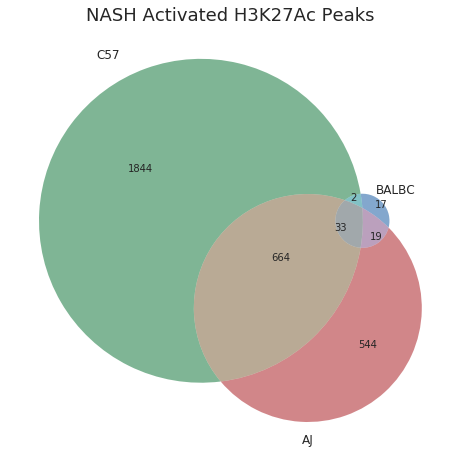

In [27]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn3(subsets=(len(C57_private),
               len(balbc_private),
               len(C57_balbc),
               len(aj_private),
               len(C57_aj),
               len(balbc_aj),
               len(all3)),
     ax=ax,
     set_colors=('#006d2c', '#08519c', '#a50f15'),
     set_labels=('C57', 'BALBC', 'AJ'),
     alpha=0.5)
ax.set_title('NASH Activated H3K27Ac Peaks');

plt.savefig('./figures/venn3_activated_peaks.png', bbox_inches='tight')

In [28]:
all3 = set(peak_dict['C57'][1]).intersection(set(peak_dict['balbc'][1]).intersection(peak_dict['aj'][1]))
C57_balbc = set(peak_dict['C57'][1]).intersection(set(peak_dict['balbc'][1]).difference(all3))
C57_aj = set(peak_dict['C57'][1]).intersection(set(peak_dict['aj'][1]).difference(all3))
balbc_aj = set(peak_dict['balbc'][1]).intersection(peak_dict['aj'][1]).difference(all3)
C57_private = set(peak_dict['C57'][1]).difference(set(all3).union(set(C57_balbc).union(C57_aj)))
balbc_private = set(peak_dict['balbc'][1]).difference(set(all3).union(set(C57_balbc).union(balbc_aj)))
aj_private = set(peak_dict['aj'][1]).difference(set(all3).union(set(C57_aj).union(balbc_aj)))

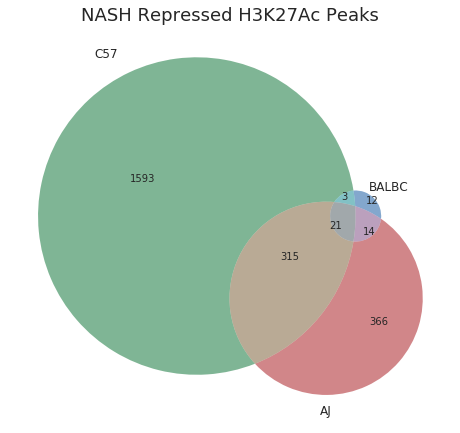

In [29]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn3(subsets=(len(C57_private),
               len(balbc_private),
               len(C57_balbc),
               len(aj_private),
               len(C57_aj),
               len(balbc_aj),
               len(all3)),
     ax=ax,
     set_colors=('#006d2c', '#08519c', '#a50f15'),
     set_labels=('C57', 'BALBC', 'AJ'),
     alpha=0.5)
ax.set_title('NASH Repressed H3K27Ac Peaks');

plt.savefig('./figures/venn3_repressed_peaks.png', bbox_inches='tight')